<a href="https://colab.research.google.com/github/digitalminimal/w5/blob/main/d4/W5D4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from IPython.display import Image

In [22]:
Image("img/1.png")

In [23]:
Image("img/2.png")

In [24]:
# And import the libraries
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

%pylab inline
!pip install git+git://github.com/mgelbart/plot-classifier.git #plot_classifier install
from plot_classifier import plot_classifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

# train test split and cross validation
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

pd.set_option("display.max_colwidth", 200)

Populating the interactive namespace from numpy and matplotlib
  Cloning git://github.com/mgelbart/plot-classifier.git to /tmp/pip-req-build-o9ba87mx
  Running command git clone -q git://github.com/mgelbart/plot-classifier.git /tmp/pip-req-build-o9ba87mx


## Review: Conditional probabilities

- Conditional probabilities are a way of using information we have about random variables.
- For example, for a fair 6-sided dice, what if we already know the roll is odd, because someone told us. What are the 6 _conditional_ probabilities of each outcome?
  - They are: {3: 1/3, 5: 1/3, 1: 1/3, 2: 0/3, 4: 0/3, 6: 0/3}
- We write conditional probabilities with a vertical bar, `|`. The information we're conditioning on goes after the bar.
  - E.g., $P(X=i \mid \text{X is odd})$ is a **conditional probability**
  - The set of these values form the **conditional distribution**
    - Conditional distributions are still probability distributions - they must sum up to 1.

- So, what's the pattern here?
  - The conditioning _eliminates some possible outcomes_.
  - For the remaining outcomes, we _renormalized_ the distribution.
  - That is, we took the proportion of the allowed outcomes that satisfy the event description.

### Conditional probabilities - formalizing things

The key equation with conditional probabilities is

$$P(A\mid B)=\frac{P(A \cap B)}{P(B)}$$

The "renormalizing" trick is a consequence of this. 

Consider, what's the probability of rolling a 6 given that the roll is not 1?

- Let $A$ be the roll is a 6
- Let $B$ be the roll is a not a 1

$$P(A\mid B)=\frac{P(A \cap B)}{P(B)}=\frac{P(A)}{P(B)}=\frac{1/6}{5/6}=\frac{1}{5}$$

In this case, we had the simplification that $P(A\cap B)=P(A)$. WHY? This is often not the case.

### Bayes' Theorem

In [25]:
Image("img/bayesthm.jpeg",width = 600, height = 300)

In [26]:
Image("img/bayesexample.PNG",width = 600, height = 300)

**Another Example:** A heritable disease occurs randomly in 10% of the population. If someone has the disease, it is passed on to their children with probability 50%. A mother has 1 healthy child. Given this, what's the conditional probability that the mother has the disease? 

- Is the answer 10%? Less? More? How do we quantify it?
  - Let $M$ be the event that the mother has the disease.
  - Let $C$ be the event that the child has the disease.
  - We want $P(M\mid \textrm{not } C)$. We have $P(M)=0.1$ and $P(\textrm{not }C\mid M)=0.5$.

Solution:

$$P(M \mid \textrm{not } C) = \frac{P(\textrm{not } C \mid M)P(M)}{P(\textrm{not } C)}$$

So we still need $P(\textrm{not } C)$. This could happen in 2 ways ("law of total probability")

$$P(\textrm{not } C)=P(\textrm{not } C \mid M)P(M) + P(\textrm{not } C \mid \textrm{not } M)P(\textrm{not } M)$$

We know $P(\textrm{not } M)=1-P(M)=0.9$.   
We assume $P( C \mid \textrm{not } M)=0.1$ because the child can randomly get the disease like anyone else,   
so then $P(\textrm{not } C \mid \textrm{not } M)=1-P( C \mid \textrm{not } M)=0.9$. 

Finally, then, we're left with:

$$P(M \mid \textrm{not } C) = \frac{0.5 \times 0.1}{0.5\times 0.1 + 0.9 \times 0.9} = 0.058$$


- We can get what we need using **Bayes' Theorem**.

If curious, you should also review:
- Law of Total Probability  $P(X=x)=\sum_y P(X=x\mid Y=y)P(Y=y)$

## Naive Bayes

- For years, best spam filtering methods used naive Bayes.
- Our first probabilistic classifier where we **think of learning as a problem of statistical inference**.

- Classification technique based on Bayes’ Theorem **with an assumption of independence among predictors** - hence the Naive. 
    - The presence of a particular feature in a class is unrelated to the presence of any other feature.
    - This is like saying: If you are hungry the probability of the symptoms(growling stomach, mouth watering, weakness,...) manifesting are independant 

E.g. You receive a spam mail that contains the words "Money", "URGENT!", "Prize!". Even if these features depend on each other or others, all of these properties independently contribute to the probability that this email is SPAM.

- Naive Bayes is easy to build and useful for very large data sets. 

- Naive Bayes outperforms even highly sophisticated classification methods and works well with text data.

## Naive Bayes Classifier


Before understanding the theory, let's try `scikit-learn`'s implementation of Naive Bayes on Kaggle's [SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset).

#### We will use `CountVectorizer` to get bag-of-words (BOW) representation - We will come back to this later in more detail!

- So we used `CountVectorizer` to convert text data into feature vectors where
    - each feature is a unique word in the text  
    - each feature value represents the frequency or presence/absence of the word in the given message         
    
<img src='./img/bag-of-words.png' width="600">

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

In [27]:
sms_df = pd.read_csv("spam.csv", encoding="latin-1")
sms_df = sms_df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [28]:
train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
X_train, y_train = train_df["sms"], train_df["target"]
X_test, y_test = test_df["sms"], test_df["target"]

In [29]:
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so ...
1283,ham,Yes i thought so. Thanks.
2327,spam,"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm"
1103,ham,Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.


In [30]:
from sklearn.naive_bayes import MultinomialNB

pipe_nb = make_pipeline(CountVectorizer(), MultinomialNB())
pipe_nb.fit(X_train, y_train)
print("Training Acc.: ", pipe_nb.score(X_train,y_train))
print("Valid Acc.: ", pipe_nb.score(X_test,y_test))

Training Acc.:  0.9932690150325331
Valid Acc.:  0.9865470852017937


### Naive Bayes `predict`

- Given a new message, we want to predict whether it's spam or non spam (ham).
- Example: Predict whether the following message is spam or non spam (ham). 
> "URGENT! Free!!"

In [31]:
deploy_test = ["URGENT! Free!!", "I like learning about stats!"]
pipe_nb.predict(deploy_test)

array(['spam', 'ham'], dtype='<U4')

### Probabilistic classifiers: `predict` by hand 

- What's it's doing under the hood? 
- Let's look at an example with a toy dataset. 

In [32]:
X = [
    "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
    "Lol you are always so convincing.",
    "Block 2 has interesting courses.",
    "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
    "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!",
    "Block 2 has been interesting so far.",
]
y = ["spam", "non spam", "non spam", "spam", "spam", "non spam"]

In [33]:
pipe_nb_toy = make_pipeline(CountVectorizer(max_features = 4, stop_words='english'), MultinomialNB())
pipe_nb_toy.fit(X, y);

In [34]:
data = pipe_nb_toy['countvectorizer'].transform(X)
train_bow_df = pd.DataFrame(data.toarray(), columns=pipe_nb_toy['countvectorizer'].get_feature_names(), index=X)
train_bow_df['target'] = y

In [35]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


Suppose we are given text messages in `deploy_test` and we want to find the targets for these examples, how do we do it using naive Bayes?

First, let's get numeric representation of our text messages. 

In [36]:
deploy_test = ["URGENT! Free!!", "I like Week 5 block better."]
data = pipe_nb_toy['countvectorizer'].transform(deploy_test).toarray()
bow_df = pd.DataFrame(data, columns=pipe_nb_toy['countvectorizer'].get_feature_names(), index=deploy_test)


In [37]:
bow_df

,block,free,prize,urgent
URGENT! Free!!,0,1,0,1
I like Week 5 block better.,1,0,0,0


### Naive Bayes prediction idea

Suppose we want to predict whether the following message is "spam" or "non spam".
> "URGENT! Free!!"

Representation of the message: `[0, 1, 0, 1]`

To predict the correct class, naive Bayes calculates the following probability scores using Bayes Theorem. 

- $P(\text{spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})$ 
- $P(\text{non spam} \mid  \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})$
- **Picks the label with higher probability scores**. 

### Applying Bayes' theorem 

Uses Bayes' theorem to calculate probabilities:

$$P(A \mid B) = \frac{P(B \mid A) \times P(A)}{P(B)}$$

$$P(\text{spam} \mid \text{message})= \frac{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})}{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})}$$

$$P(\text{non spam} \mid \text{message}) = \frac{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{non spam}) \times P( \text{non spam})}{P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent=1})}$$

- $P(\text{message})$: marginal probability that a message has the given set of words 
    - Hard to calculate but can be ignored in our scenario as it occurs in the denominator for both $P(\text{spam} \mid \text{message})$ and $P(\text{non spam} \mid \text{message})$.
    - So we ignore the denominator in both cases. 


### Let's focus on $P(\text{spam} \mid \text{message})$

- After ignoring the denominator: 
$$P(\text{spam} \mid \text{message}) \propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})$$

- To calculate $P(\text{spam} \mid \text{message})$, we need:  
    - $P(\text{spam})$: marginal probability that a message is spam
    - $P(\text{message}\mid\text{spam})$: conditional probability that message has words $w_1, w_2, \dots, w_d$, given that it is spam.
        - Hard to calculate because it would require huge numbers of parameters and impossibly large training sets. But we need it. 
        - with $d$ binary features, how many possible "text messages" are there?
        - we cannot possibly have access to all the data

### Naive Bayes' approximation to calculate $P(\text{message}|\text{spam})$

- A common assmption is **naive Bayes** assumption, which states that **features are independent, conditioned on the target**. 
    - Example: In our spam classification example, **once you know that a message is spam**, the probability that the word "urgent" appears is independent of whether "free" also appeared. Think back to our analogy of getting hungry and the symptoms associated with that...
    
- We can write this mathematically as 

$$\begin{equation}
\begin{split}
& P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \\
&\approx P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam})
\end{split}
\end{equation}$$


### Naive Bayes' approximation

- In general, 
$$P(\text{message} \mid \text{spam}) = P(w_1, w_2, . . . , w_d \mid \text{spam}) \approx \prod_{i=1}^{d}P(w_i \mid \text{spam})$$

$$P(\text{message} \mid \text{non spam}) = P(w_1, w_2, . . . , w_d \mid \text{non spam}) \approx \prod_{i=1}^{d}P(w_i \mid \text{non spam})$$


### Going back to estimating $P(\text{spam} \mid \text{message})$

With naive Bayes' assumption, to calculate $P(\text{spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1)$, we need the following:  
1. Prior probability: $P(\text{spam})$ 
2. Conditional probabilities: 
    1. $P(\text{block} = 0 \mid \text{spam})$
    2. $P(\text{free} = 1 \mid \text{spam})$
    3. $P(\text{prize} = 0 \mid \text{spam})$
    4. $P(\text{urgent} = 1 \mid \text{spam})$

We use our training data to calculate these probabilities. 

In [38]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


- Prior probability
    - $P(\text{spam}) = 3/6$
    
- Conditional probabilities
    - What is $P(\text{block} = 0 \mid \text{spam})$? 
        - Given target is spam, how often "block" = 0? $3/3$
    - $P(\text{free} = 1 \mid \text{spam}) = 2/3$ 
    - $P(\text{prize} = 0 \mid \text{spam}) = 1/3$
    - $P(\text{urgent} = 1 \mid \text{spam}) = 2/3$

### Estimating $P(\text{spam} \mid \text{message})$

$$\begin{equation}
\begin{split}
P(\text{spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto P(\text{block} = 0 \mid \text{spam}) \times P(\text{free} = 1 \mid \text{spam}) \\
& \times P(\text{prize} = 0 \mid \text{spam}) \times P(\text{urgent} = 1 \mid \text{spam}) \times P(\text{spam})\\
&\propto 3/3 \times 2/3 \times 1/3 \times 2/3 \times 3/6\\
\end{split}
\end{equation}$$


In [39]:
spam_prior = 3/6
block0_spam = 3/3
free1_spam = 2/3
prize0_spam = 1/3
urgent1_spam = 2/3
print((spam_prior * block0_spam * free1_spam * prize0_spam * urgent1_spam))

0.07407407407407407


### Let's estimate $P(\text{non spam} \mid \text{message})$

With naive Bayes' assumption, to calculate $P(\text{non spam} \mid \text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1)$, we need the following:  
1. Prior probability: $P(\text{non spam})$ 
2. Conditional probabilities: 
    1. $P(\text{block} = 0 \mid \text{non spam})$
    2. $P(\text{free} = 1 \mid \text{non spam})$
    3. $P(\text{prize} = 0 \mid \text{non spam})$
    4. $P(\text{urgent} = 1 \mid \text{non spam})$

Again we use the data to calculate these probabilities. 

In [40]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


- Prior probability 
    - $P(\text{non spam}) = 3/6$

- Conditional probabilities 
    - What is $P(\text{block} = 0 \mid \text{non spam})$? 
        - Given target is non spam, how often "block" = 0? $1/3$
    - $P(\text{free} = 1 \mid \text{non spam}) = 0/3$ 
    - $P(\text{prize} = 0 \mid \text{non spam}) = 3/3$
    - $P(\text{urgent} = 1 \mid \text{non spam}) = 0/3$

### Estimating $P(\text{non spam} \mid \text{message})$

$$\begin{equation}
\begin{split}
P(\text{non spam} \mid \text{message}) &\propto P(\text{block} = 0, \text{free} = 1, \text{prize} = 0, \text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto P(\text{block} = 0 \mid \text{non spam}) \times P(\text{free} = 1 \mid \text{non spam}) \\
& \times P(\text{prize} = 0 \mid \text{non spam}) \times P(\text{urgent} = 1 \mid \text{non spam}) \times P(\text{non spam})\\
&\propto 1/3 \times 0 \times 3/3 \times 0 \times 1/3\\
\end{split}
\end{equation}$$


In [41]:
non_spam_prior = 3/6
block0_non_spam = 0/3
free1_non_spam = 1/3
prize0_non_spam = 1/3
urgent1_non_spam = 2/3
print(non_spam_prior * block0_non_spam * free1_non_spam * prize0_non_spam * urgent1_non_spam)

0.0


### Naive Bayes prediction

Since $(\text{spam} \mid \text{message})$ (0.074) is proportional to a larger number compared to $(\text{non spam} \mid \text{message})$ (0), we predict $spam$! 

## 2. `predict_proba`

### What is our toy pipeline's prediction? 

In [42]:
deploy_test = ["URGENT! Free!!"]
pipe_nb_toy.predict(deploy_test)

array(['spam'], dtype='<U8')

### Naive Bayes classifier `predict_proba`
- So far we have been looking into binary predictions but often a more granular information is useful. 
- Naive Bayes classifier gives you probability estimates for each class and we can get this information using `predict_proba` method of the classifier.  

In [43]:
pipe_nb_toy.predict_proba(deploy_test)

array([[0.23584906, 0.76415094]])

In [44]:
pipe_nb_toy.classes_

array(['non spam', 'spam'], dtype='<U8')

Above: The classifier is "76% confident" that the class is spam! 

### Predicting probabilities

- We have a new and useful method, `predict_proba`.
- `predict` returns the class with the highest probability.
- `predict_proba` gives us the actual probability scores. 
- Looking at the probabilities can help us understand the model.
- We can find the spam messages where our classifier is most confident and least confident. 

### Why don't the calculations match?

- Recall that when we worked through a toy example by hand, we estimated
    - $P(\text{non spam} \mid \text{message}) \propto 0$
    - $P(\text{spam} \mid \text{message}) \propto 0.074$
- Why don't `predict_proba` scores match with the probability scores we calculated before? 
- The scores we computed are not normalized. Remember that we ignored the denominator.
- These ones are normalized so that they sum to 1.
- The model is using something called "smoothing" to avoid the problem of zero probabilities. 

## 3. Laplace smoothing



In [45]:
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,1,1,spam
Lol you are always so convincing.,0,0,0,0,non spam
Block 2 has interesting courses.,1,0,0,0,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,1,1,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,0,1,0,0,spam
Block 2 has been interesting so far.,1,0,0,0,non spam


- Remember when we calculated $P(\text{non spam} \mid \text{message})$, some of our conditional probabilities were zero. 
    - $P(\text{free} = 1 \mid \text{non spam}) = 0/3$ 
    - $P(\text{urgent} = 1 \mid \text{non spam}) = 0/3$

- Naive Bayes naively multiplies all the feature likelihoods together, and if any of the terms is zero, it's going to void all other evidence and the probability of the class is going to be zero. 
- This is problematic! 
- **We have limited data and if we do not see a feature occurring with a class, it doesn't mean it would never occur with that class**. 

### A simple solution: Laplace smoothing

- The simplest way to avoid zero probabilities is to add one to all the counts.
- All the counts that used to be zero will now have a count of 1, the counts of 1 will be 2, and so on. 
- In `scikit-learn` we control it using hyperparameter `alpha` (by default `alpha=1.0`). 


So our previous bag of words representation becomes like this: 

In [46]:
data = pipe_nb_toy['countvectorizer'].transform(X)
train_bow_df = pd.DataFrame(data.toarray() + 1, columns=pipe_nb_toy['countvectorizer'].get_feature_names(), index=X)
train_bow_df['target'] = y
train_bow_df

,block,free,prize,urgent,target
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,1,1,2,2,spam
Lol you are always so convincing.,1,1,1,1,non spam
Block 2 has interesting courses.,2,1,1,1,non spam
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,1,2,2,2,spam
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free!,1,2,1,1,spam
Block 2 has been interesting so far.,2,1,1,1,non spam


### Adjusting the counts 

Note that the following calculations would change now with updated counts now: 

$$P(\text{word} \mid \text{spam}) = \frac{Count(\text{word}, \text{spam}) + 1}{\sum_{w \in vocabulary} Count(w, \text{spam}) + |vocabulary|}$$

### `alpha` hyperparameter and the fundamental tradeoff 

- High alpha $\rightarrow$ underfitting
    - means we are adding large counts to everything and so we are diluting the information from the data
- Low alpha $\rightarrow$ overfitting

###  Gaussian Naive Bayes

- If a dataset has continuous-valued features.
- But so far, we've only seen how to use Naive Bayes for discrete features.
- We can either discretize our continuous features into discrete bins (with counts), or...
- Use _Gaussian_ naive Bayes (read more [here](https://machinelearningmastery.com/naive-bayes-for-machine-learning/) and [here](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes))
- Now:
    - Assume each feature is normally distributed 
    - Calculate the mean ($\mu_k$) and standard deviation ($\sigma_k$) for each feature for each class
    - Use the following equation to calculate the conditional probability of observing feature value $v$ (occurence of a word in our previous example) in class $C_k$ (Spam/ham in our previous example)

<img src='./img/gaus_nb.png' width="250">


Source: [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Gaussian_naive_Bayes)

- Gaussian naive Bayes assumes features are normally distributed
    - Are our features normal?
    - Not really but in practice we transform our data to try and make it more normal
    - Scikit-learn provides the `PowerTransformer()` for this process
    - From the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer): "*...Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like.*"    

### Pros of naive Bayes

- Surprising accuracy 
- A fast and robust way to learn the corresponding parameters
- Scales great; learning a naive Bayes classifier is just a matter of counting how many times each attribute co-occurs with each class
- Can be easily used for multi-class classification. 
- It's closely related to linear classifiers we'll see in the next lecture. 
    - When we take the logarithms, the products (from the Naive bayes assumption) turn into summations. 
- Can provides a informative set of features from which to predict the class (next class)

### Cons of naive Bayes

- Assumes that spammers generate e-mails by picking words at random. It means that sentences have no syntax and content. Is that a fair assumption? 
    - oversimplification 
    - sometimes the best theories are the most oversimplified, provided their predictions are accurate, because they explain the most with the least. 



## Support Vector Machines

In [47]:
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC, SVR, LinearSVC

# Other
import pandas as pd
import numpy as np

from plot_classifier import plot_classifier
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from plot_classifier import plot_classifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

- Similarity-based algorithm.
- Superficially, SVMs are more like weighted $k$-NNs. $k$-NNs are the Supervised Learning cousin of K-means.
    - The decision boundary is defined by **a set of positive and negative examples** and **their weights** together with **their similarity measure**. 
    - A test example is a positive if on average it looks more like positive examples than the negative examples. 

- What makes SVMs special is that they only remember key examples (support vectors). So it's more efficient than other similarity-based algorithms.

- SVMs use a similarity metric which is called a "kernel" in SVM land. A popular kernel is Radial Basis Functions (RBFs) which we will use today.
- https://en.wikipedia.org/wiki/Radial_basis_function_kernel

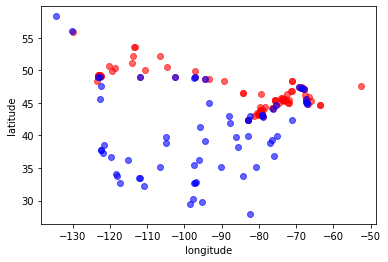

In [50]:
cities_df = pd.read_csv('canada_usa_cities.csv')
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
canada = train_df.query('country == "Canada"')
usa = train_df.query('country == "USA"')
plt.scatter(canada["longitude"], canada["latitude"], color="red", alpha=0.6)
plt.scatter(usa["longitude"], usa["latitude"], color="blue", alpha=0.6)
plt.ylabel("latitude")
plt.xlabel("longitude");

In [51]:
# split into training/validation and testing set
X_train, y_train = train_df.drop(columns=['country']), train_df['country']
X_test, y_test = test_df.drop(columns=['country']), test_df['country']

In [52]:
from sklearn.svm import SVC

svm = SVC(gamma=0.01) # Ignore gamma for now
svm.fit(X_train, y_train)
print("Train scores: ", round(svm.score(X_train, y_train), 4))
print("Test scores: ", round(svm.score(X_test, y_test), 4))

Train scores:  0.8383
Test scores:  0.8333


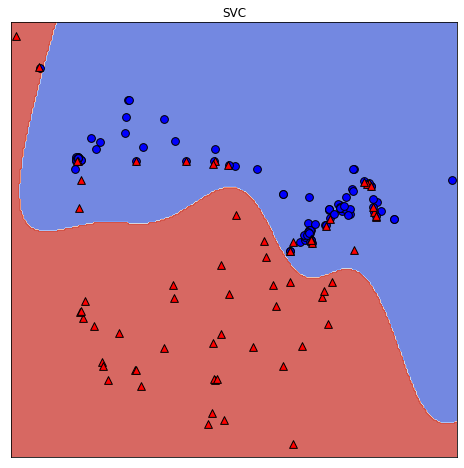

In [53]:
# You can think of SVM with RBF kernel as "smooth KNN"
plt.figure(figsize=(8, 8))
plt.title("SVC")
plot_classifier(X_train, y_train, svm, ax=plt.gca());

#### Support vectors 

- Each training example either is or isn't a "support vector".
  - This gets decided during `fit`.

- **Main insight: the decision boundary only depends on the support vectors.**

- Let's look at the support vectors. 

SVM is going to leverage the dataset and find the best values **$w^{(*)}$** and **$b^{(*)}$** for parameters $w$ and $b$. 

Then, the learning algorithm is defined as:

> $f(x) = sign(w^{(*)}x − b^{(*)})$

Now, to predict whether a **new** review is positive or negative using an SVM model, you have to take the text of the review, convert it into a feature vector, then multiply this vector by **$w^{(*)}$** , subtract **$b^{(*)}$** and take the sign of the result. 

If you get +1, then, the review is a positive review. If you get a -1, then, you have a negative review. 

We want a hyperplane that separates positive examples from negative ones with the **largest margin**. 

If the margin or decision boundary is large, it contributes to a better generalization, that is how well the model will classify new examples in the future. 

<img src="img/svmplanes.PNG" style="width: 700px;"/>

For two-dimensional feature vectors, we can easily visualize the solution. The blue and orange circles represent, respectively, positive and negative examples. The line given by $wx − b = 0$ is the decision boundary.

That’s how Support Vector Machines work. This particular version of the algorithm builds the so-called linear model. It’s called linear because the decision boundary is a straight line (or a plane, or a hyperplane).

<img src="img/img1.png" alt="Drawing" style="width: 600px;"/>

In [ ]:
# demo with a synthetic data set
n = 20
X = np.random.randn(n,2)
y = np.random.choice((-1,+1),size=n)
X[y>0,0] -= 2
X[y>0,1] += 2

In [ ]:
svm = SVC(kernel="linear", C=1e6) # ignore the C=1e6 for now
svm.fit(X,y)

plt.figure(figsize=(4,4))
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);

- The support vectors (SVs) are shown in yellow.
- These are the example that "support" the boundary. 

Below: let's try removing all other examples, keeping only the SVs.

In [ ]:
sv = svm.support_
not_sv = list(set(range(n)) - set(sv))

In [ ]:
# remove all non-support vectors
X3 = np.delete(X,not_sv,0)
y3 = np.delete(y,not_sv,0)

svm3 = SVC(kernel="linear", C=1e6)
svm3.fit(X3,y3)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");
plt.subplot(1,2,2)
plot_classifier(X3,y3,svm3, ax=plt.gca(), lims=(X[:,0].min()-1,X[:,0].max()+1,X[:,1].min()-1,X[:,1].max()+1))
plt.title("SVs only");

print(svm.coef_)
print(svm3.coef_)
print("The coefficients are the same!")

In [ ]:
# remove a support vector
X2 = np.delete(X,sv[0],0)
y2 = np.delete(y,sv[0],0)

svm2 = SVC(kernel="linear", C=1e6)
svm2.fit(X2,y2);

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plot_classifier(X,y,svm, ax=plt.gca())
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.title("Original");

plt.subplot(1,2,2)
plot_classifier(X2,y2,svm2, ax=plt.gca())
# plt.scatter(*svm2.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.scatter(svm.support_vectors_[0,0], svm.support_vectors_[0,1], marker="x", c="yellow")
plt.title("With one SV removed");

print(svm.coef_)
print(svm2.coef_)

- The **margin** is the distance from the boundary to the nearest point(s).
- Maximizing the margin is a "maximin" problem: maximize the minimum distance to the boundary.
- Intuitively, more margin is good because it leaves more "room" before we make an error.
- Above: it looks like SVM maximizes the margin.
- QUESTION: What does linear regression do?

In [ ]:
plt.figure()
plot_classifier(X, y, svm, ax=plt.gca());
plt.scatter(*svm.support_vectors_.T, marker="o", edgecolor="yellow", facecolor="none", s=120);
plt.axis('equal');
plt.axis('square');

def SV_proj(svm):
    v = svm.support_vectors_
    s = np.array([svm.coef_.flatten()[1], -svm.coef_.flatten()[0]])
    w = svm.coef_
    return (v@s[:,None])/(s@s) * s - w/(w@w.T)*svm.intercept_
proj = SV_proj(svm)

for i in range(len(proj)):
    p = proj[i]
    sv = svm.support_vectors_[i]
    plt.plot((p[0],sv[0]),(p[1],sv[1]), 'yellow')

### Hyperparameters of SVM 

- Key hyperparameters of `rbf` SVM are
    - `gamma`
    - `C`
    
- We are not equipped to understand the meaning of these parameters at this point but you are expected to describe their relation to the fundamental tradeoff. 

See [`scikit-learn`'s explanation of RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html). 

### Relation of `gamma` and the fundamental trade-off

- `gamma` controls the complexity (fundamental trade-off), just like other hyperparameters we've seen.
  - larger `gamma` $\rightarrow$ more complex $\rightarrow$ can lead to overfitting
  - smaller `gamma` $\rightarrow$ less complex $\rightarrow$ can lead to underfitting

### Relation of `C` and the fundamental trade-off

- `C` _also_ affects the fundamental tradeoff
    - larger `C` $\rightarrow$ more complex $\rightarrow$ can lead to overfitting
    - smaller `C` $\rightarrow$ less complex $\rightarrow$ can lead to underfitting

**C helps us deal with Noise**

To extend SVM to cases in which the data is not linearly separable, we introduce the Hinge Loss Function: 

$max(0, 1− y_i(wx_i − b))$. *don't worry too much about this.

The Hinge Loss Function is zero if $wx_i$ lies on the correct side of the decision boundary. 
For data on the wrong side of the decision boundary, the function’s value is proportional to the distance from the decision boundary.


By changing the Hyperparamenter C, we determine the tradeoff between increasing the size of the decision boundary and trying to get each $x_i$ in the correct side of the decision boundary. 

SVMs that optimize hinge loss are called **soft-margin SVMs**, while the original formulation is referred to as a **hard-margin SVM**.

For sufficiently high values of C, the second term in the cost function will become negligible, so the SVM algorithm will try to find the highest margin by completely ignoring misclassification. As we decrease the value of C, making classification errors is becoming more costly, so the SVM algorithm tries to make fewer mistakes by sacrificing the margin size. **A larger margin is better for generalization.**

C regulates the tradeoff between classifying the training data well (minimizing empirical risk) and classifying future examples well (generalization).

<img src="img/img4.png" alt="Drawing" style="width: 400px;"/>

### The Kernel Trick

1. What if there’s noise in the data and no hyperplane can perfectly separate positive examples from negative ones?
2. What if the data cannot be separated using a plane, but could be separated by a higher-order polynomial?

SVM can also incorporate kernels that can make the decision boundary arbitrarily non-linear. In some cases, it could be impossible to perfectly separate the two groups of points because of noise in the data, errors of labeling, or outliers. 

You can see both situations in the next figure. In the left case, the data could be separated by a straight line if not for the noise (outliers or examples with wrong labels). 

In the right case, the decision boundary is a circle and not a straight line.

<img src="img/img2.png" alt="Drawing" style="width: 500px;"/>

**Dealing with Inherent Non-Linearity**
SVM can be adapted to work with datasets that cannot be separated by a hyperplane in its original space. Indeed, if we manage to transform the original space into a space of higher dimensionality, we could hope that the examples will become linearly separable in this transformed space. In SVMs, using a function to implicitly transform the original space into a higher dimensional space during the cost function optimization is called the kernel trick.

<img src="img/img3.png" alt="Drawing" style="width: 600px;"/>

It’s possible to transform a two-dimensional non-linearly-separable data into a linearly-separable threedimensional
data using a specific mapping. For example: 2D data into a 3D space. Now, the data becomes
linearly separable in the transformed space.

However, we don’t know a priori which mapping would work for our data. 



By using the kernel trick, we can get rid of a costly transformation of original feature vectors into higher dimensional vectors and avoid computing their dot-product.

In [ ]:
n = 20
d = 2
np.random.seed(0)
X = np.random.randn(n,d)
y = np.sum(X**2,axis=1) < 0.4

plt.scatter(X[:,0], X[:,1], c=y);
plt.xlabel("$x_{i1}$", fontsize=20);
plt.ylabel("$x_{i2}$", fontsize=20);

In [ ]:
svm = SVC(kernel="linear")
svm.fit(X,y)

plot_classifier(X,y,svm)

print("Training accuracy", svm.score(X,y))

In [ ]:
Z = X**2

plt.scatter(Z[:,0], Z[:,1], c=y);
plt.xlabel("$z_{i1}$", fontsize=20);
plt.ylabel("$z_{i2}$", fontsize=20);

In [ ]:
svm = SVC(kernel="linear", C=100)
svm.fit(Z,y)

plot_classifier(Z,y,svm)

print("Training accuracy", svm.score(Z,y))

In [ ]:
plot_classifier(X, y, svm, transformation=lambda X: X**2);